# Comparison of Classical Machine Learning and Neural Networks  
## Breast Cancer Diagnosis


## 1. Introduction

This project compares classical machine learning models (Logistic Regression and Random Forest) 
with a Neural Network implemented in PyTorch for breast cancer diagnosis.

This aims to evaluate whether deep learning significantly outperforms traditional ML 
for structured biomedical tabular data.

**Import Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, roc_curve, confusion_matrix)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import torch
import torch.nn as nn
import torch.optim as optim


sns.set(style="whitegrid")

### Loading the Dataset

The Breast Cancer Wisconsin dataset is loaded from sklearn.


In [2]:
data = load_breast_cancer()

X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

print("Dataset Shape:", X.shape)
print("\nClass Distribution:\n", y.value_counts())

Dataset Shape: (569, 30)

Class Distribution:
 1    357
0    212
Name: count, dtype: int64


## 2. Dataset Overview and Characteristics

The Breast Cancer Wisconsin dataset contains 30 continuous
features computed from cell nucleus characteristics.
The task is binary classification (malignant vs benign).


**Class Distribution Plot**


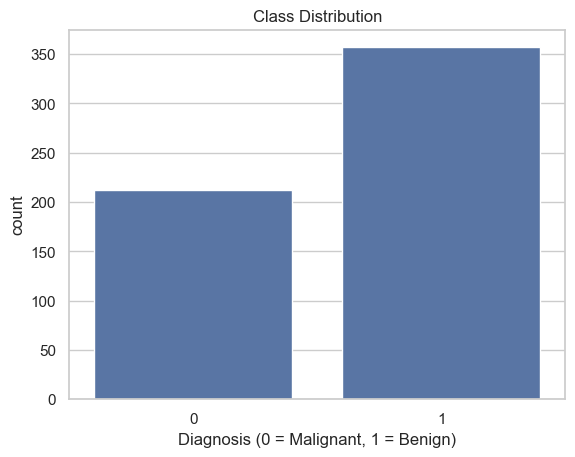

In [3]:
sns.countplot(x=y)
plt.xlabel("Diagnosis (0 = Malignant, 1 = Benign)")
plt.title("Class Distribution")
plt.show()

The class distribution plot shows a mild imbalance,
with more benign cases than malignant cases.
However, the imbalance is not severe and does not
require additional re-sampling techniques.

### Correlation Heatmap
To investigate multicollinearity among features,
a correlation heatmap is generated.
Highly correlated features may influence model behavior,
especially for linear models.

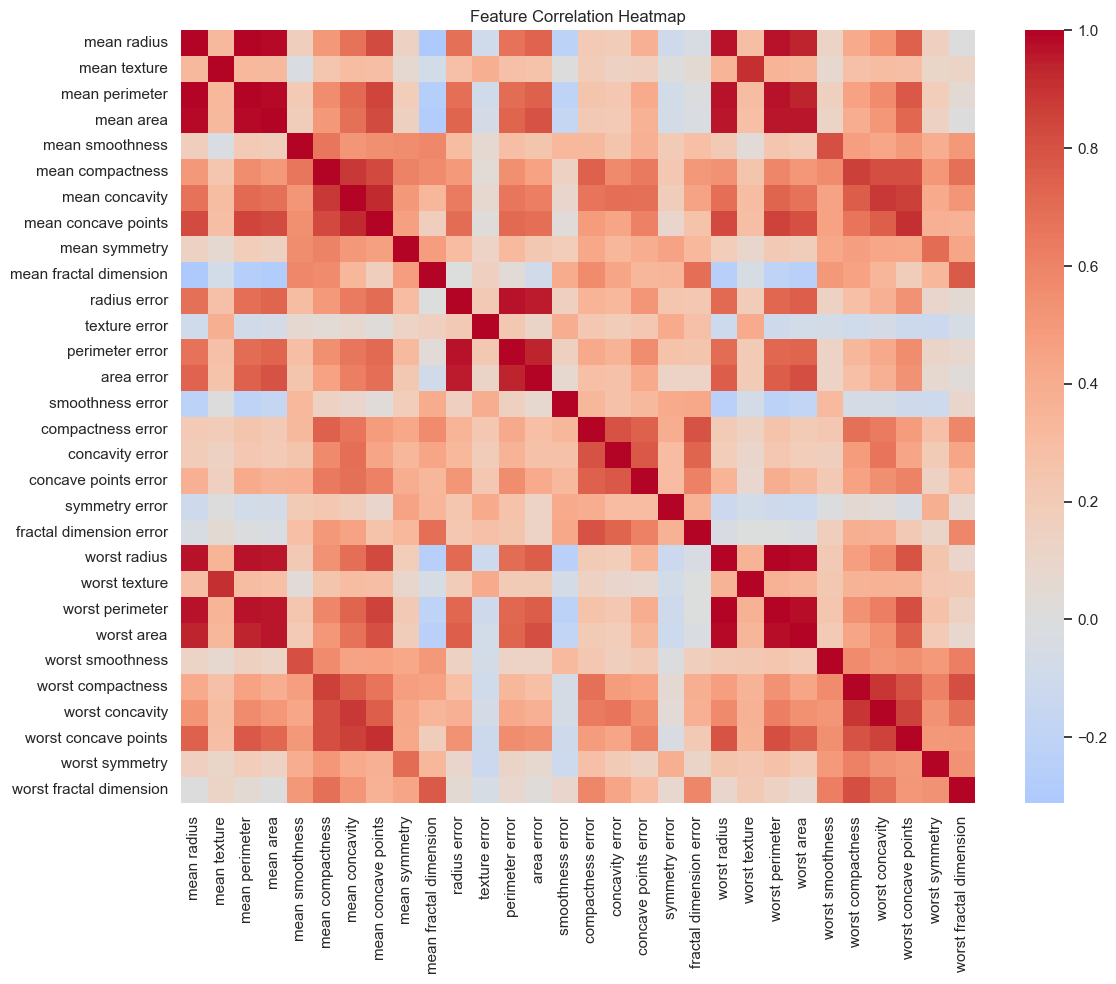

In [4]:
plt.figure(figsize=(12,10))
sns.heatmap(X.corr(), cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

The correlation heatmap reveals strong multicollinearity among size-related features such as radius, perimeter, and area. This indicates that several variables capture similar structural properties of the tumor.

### PCA Visualization
Principal Component Analysis (PCA) is applied after scaling
to visualize class separability in reduced dimensional space.

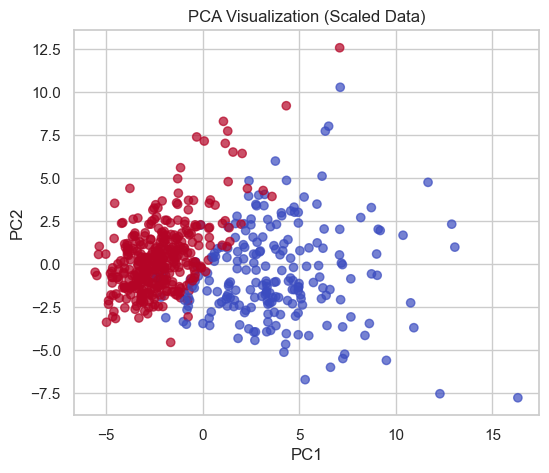

In [5]:
# Import preprocessing and dimensionality reduction tools
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Standardize the feature matrix so that each feature has mean = 0 and variance = 1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply Principal Component Analysis (PCA)
pca = PCA(n_components=2, svd_solver='full')
X_pca = pca.fit_transform(X_scaled)

# Create a 2D scatter plot of the first two principal components
plt.figure(figsize=(6,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap="coolwarm", alpha=0.7)
plt.title("PCA Visualization (Scaled Data)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

The PCA projection of the scaled data shows noticeable class separation along the first principal component, indicating that the dataset contains strong discriminative structure.

**Train/Test Split + Scaling**

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

## 3. Model Evaluation 

## MODEL 1 : Logistic Regression
Logistic Regression is used as a baseline linear classifier.
L2 regularization is applied by default.

In [8]:
# Initialize Logistic Regression model

log_model = LogisticRegression(max_iter=500)
log_model.fit(X_train, y_train)

y_pred_log = log_model.predict(X_test)
y_prob_log = log_model.predict_proba(X_test)[:,1]

In [9]:
# Evaluate model performance using multiple classification metrics

print("Logistic Regression Results")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print("Precision:", precision_score(y_test, y_pred_log))
print("Recall:", recall_score(y_test, y_pred_log))
print("F1 Score:", f1_score(y_test, y_pred_log))

Logistic Regression Results
Accuracy: 0.9736842105263158
Precision: 0.9722222222222222
Recall: 0.9859154929577465
F1 Score: 0.9790209790209791


The Logistic Regression model achieves strong performance on the test set with an accuracy of 97.4%. The high recall (98.6%) indicates that the model correctly identifies most benign cases, while precision (97.2%) shows a low false positive rate. Overall, the F1-score of 97.9% suggests a well-balanced classifier with strong generalization ability.

### Logistic Regression Regularization Comparison

We compare L1 and L2 regularization to analyze their effect on performance.
L1 can perform feature selection, while L2 is more stable in correlated feature spaces.

In [10]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

#L1 Regularization (Lasso)
log_l1 = LogisticRegression(
    solver="saga",    # Using saga solver to enable L1 regularization
    penalty="elasticnet",
    l1_ratio=1.0,      # Pure L1
    max_iter=5000,
    random_state=42
)

# L2 Regularization (Ridge)
log_l2 = LogisticRegression(
    solver="lbfgs",
    max_iter=5000,
    random_state=42
)

# Compare test accuracy for L1 vs L2 regularization
log_l1.fit(X_train, y_train)
log_l2.fit(X_train, y_train)

print("L1 Accuracy:", accuracy_score(y_test, log_l1.predict(X_test)))
print("L2 Accuracy:", accuracy_score(y_test, log_l2.predict(X_test)))

L1 Accuracy: 0.9649122807017544
L2 Accuracy: 0.9736842105263158


L2 regularization achieved higher accuracy than L1. 
Given the strong multicollinearity observed in the dataset, 
L2 regularization is better suited as it distributes weight across correlated features 
instead of eliminating them. This explains the improved performance.

## MODEL 2 : Random Forest
Random Forest is an ensemble method that captures nonlinear
relationships and provides feature importance estimates.

In [11]:
# Initialize Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:,1]

In [12]:
# Evaluate model performance using multiple classification metrics
print("Random Forest Results")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print("F1 Score:", f1_score(y_test, y_pred_rf))

Random Forest Results
Accuracy: 0.9649122807017544
Precision: 0.958904109589041
Recall: 0.9859154929577465
F1 Score: 0.9722222222222222


The Random Forest model achieves strong performance with an accuracy of 96.5%. While recall remains very high (98.6%), precision is slightly lower than Logistic Regression. The results suggest that although ensemble methods capture non-linear relationships, the dataset may already be largely linearly separable, allowing Logistic Regression to perform slightly better.

**Feature Importance**

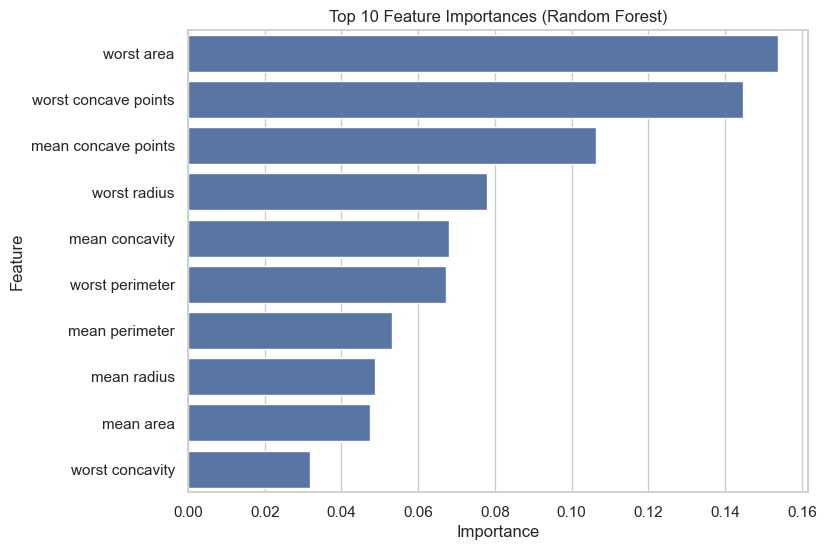

In [13]:
# Extract feature importance scores from the trained Random Forest model
importances = rf_model.feature_importances_

# Get feature names from the dataset
feature_names = X.columns

# Create a DataFrame pairing features with their importance scores
feat_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Select the top 10 most important features
top10 = feat_importance_df.head(10)

# Plot the top 10 feature importances
plt.figure(figsize=(8,6))
sns.barplot(data=top10, x="Importance", y="Feature")
plt.title("Top 10 Feature Importances (Random Forest)")
plt.show()

The Random Forest feature importance analysis shows that tumor shape-related features such as worst area, worst concave points, and mean concavity are the most influential predictors. This aligns with medical knowledge that malignant tumors tend to exhibit irregular boundaries and higher structural distortion. The dominance of geometric features suggests that tumor morphology plays a critical role in classification performance.

## MODEL 3 : Neural Network (PyTorch)
A simple feedforward neural network is implemented using PyTorch.
Architecture:
- Input: 30 features
- Hidden layer: 16 neurons (ReLU)
- Output: 1 neuron (Sigmoid)

**Convert to Tensors**

In [14]:
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train.values).view(-1,1)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test.values).view(-1,1)

**Define Model**

In [15]:


class BreastCancerNN(nn.Module):
    def __init__(self):
        super(BreastCancerNN, self).__init__()
        
        # Input layer (30 features → 16 hidden neurons)
        self.fc1 = nn.Linear(30, 16)
        
        # Activation function
        self.relu = nn.ReLU()
        
        # Output layer (binary classification)
        self.fc2 = nn.Linear(16, 1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)  # NO sigmoid here
        return x

model = BreastCancerNN()

**Loss & Optimizer**

In [16]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

**Training Loop** : 
The network is trained for 100 epochs using Binary Cross Entropy loss
and the Adam optimizer.

In [17]:
train_losses = []

for epoch in range(100):
    optimizer.zero_grad()
    
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 0.6792
Epoch 10, Loss: 0.6241
Epoch 20, Loss: 0.5697
Epoch 30, Loss: 0.5143
Epoch 40, Loss: 0.4591
Epoch 50, Loss: 0.4057
Epoch 60, Loss: 0.3566
Epoch 70, Loss: 0.3138
Epoch 80, Loss: 0.2776
Epoch 90, Loss: 0.2475


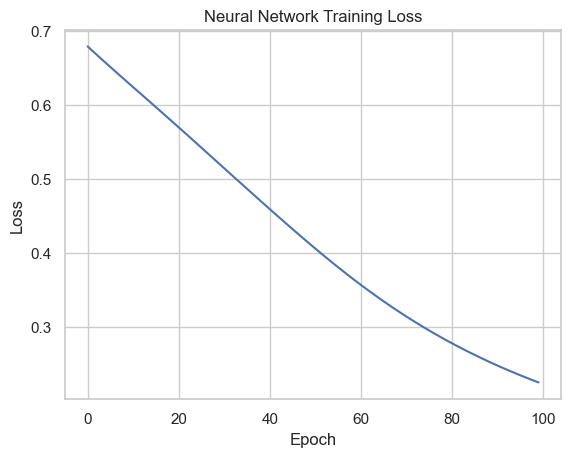

In [18]:
plt.plot(train_losses)
plt.title("Neural Network Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

**Evaluate Neural Network**

In [19]:
with torch.no_grad():
    logits = model(X_test_tensor)
    
    # Apply sigmoid manually during evaluation
    y_prob_nn = torch.sigmoid(logits)
    
    # Convert to binary predictions
    y_pred_nn = (y_prob_nn > 0.5).float()

y_pred_nn = y_pred_nn.numpy()
y_prob_nn = y_prob_nn.numpy()

In [20]:
# Function to compute evaluation metrics
def evaluate(y_true, y_pred, y_prob):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)

    return acc, prec, rec, f1, auc

In [21]:
# Evaluate Neural Network performance
nn_results = evaluate(y_test, y_pred_nn, y_prob_nn)

print("Neural Network Results")
print("Accuracy:", nn_results[0])
print("Precision:", nn_results[1])
print("Recall:", nn_results[2])
print("F1 Score:", nn_results[3])
print("AUC:", nn_results[4])

Neural Network Results
Accuracy: 0.9649122807017544
Precision: 0.958904109589041
Recall: 0.9859154929577465
F1 Score: 0.9722222222222222
AUC: 0.9967245332459875


## 4.Cross-Validation Analysis

To evaluate model robustness and generalization stability,
5-fold cross-validation is performed.

**For Logistic Regression**

In [27]:
# Perform 5-fold cross-validation for Logistic Regression
# Pipeline ensures scaling is applied inside each fold (prevents data leakage)

from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

log_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=500))
])

cv_scores_log = cross_val_score(log_pipeline, X, y, cv=5)

print("Logistic Regression CV Scores:", cv_scores_log)
print("Mean CV Accuracy:", cv_scores_log.mean())

Logistic Regression CV Scores: [0.98245614 0.98245614 0.97368421 0.97368421 0.99115044]
Mean CV Accuracy: 0.9806862288464524


**for Random Forest**

In [28]:
# Perform 5-fold cross-validation for Random Forest
# No scaling required for tree-based models

cv_scores_rf = cross_val_score(rf_model, X, y, cv=5)

print("Random Forest CV Scores:", cv_scores_rf)
print("Mean CV Accuracy:", cv_scores_rf.mean())

Random Forest CV Scores: [0.92105263 0.93859649 0.98245614 0.96491228 0.97345133]
Mean CV Accuracy: 0.9560937742586555


The 5-fold cross-validation results provide a more robust estimate of model performance.

Logistic Regression achieved a mean cross-validation accuracy of 98.07%, 
with very low variation across folds. This indicates strong stability 
and consistent generalization performance.

Random Forest achieved a mean cross-validation accuracy of 95.61%. 
While performance remains strong, greater variability across folds 
suggests slightly higher sensitivity to data partitioning.

Overall, cross-validation confirms that Logistic Regression 
generalizes more consistently on this structured tabular dataset.

## 5. Comparing the 3 models 

**Compute Metrics**

In [29]:
results = {}

results["Logistic Regression"] = evaluate(y_test, y_pred_log, y_prob_log)
results["Random Forest"] = evaluate(y_test, y_pred_rf, y_prob_rf)
results["Neural Network"] = evaluate(y_test, y_pred_nn, y_prob_nn)

**Comparison Table** : All models are evaluated using Accuracy, Precision,
Recall, F1-score, and AUC to ensure comprehensive assessment.

In [30]:
comparison = pd.DataFrame(results, 
                           index=["Accuracy","Precision","Recall","F1","AUC"]).T

comparison

,Accuracy,Precision,Recall,F1,AUC
Logistic Regression,0.973684,0.972222,0.985915,0.979021,0.997380
Random Forest,0.964912,0.958904,0.985915,0.972222,0.995251
Neural Network,0.964912,0.958904,0.985915,0.972222,0.996725


**ROC Curves**

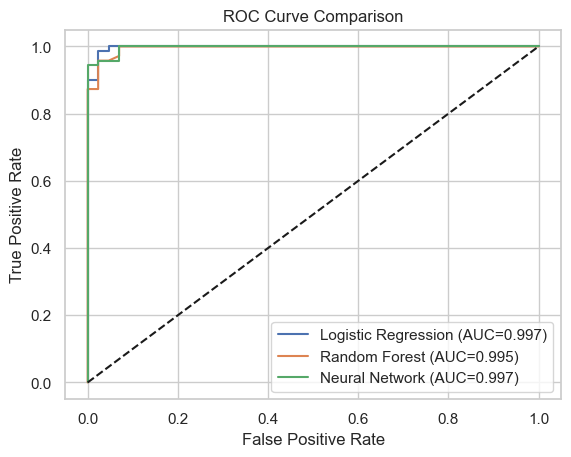

In [31]:
from sklearn.metrics import roc_curve, roc_auc_score

plt.figure()

for name in results:
    
    if name == "Logistic Regression":
        y_prob = y_prob_log
    elif name == "Random Forest":
        y_prob = y_prob_rf
    else:
        y_prob = y_prob_nn

    # Compute ROC values
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    
    # Compute AUC
    auc_score = roc_auc_score(y_test, y_prob)
    
    # Plot with AUC in legend
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc_score:.3f})")

# Random classifier reference line
plt.plot([0,1], [0,1], 'k--')

plt.legend()
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

## 6. Conclusion

- All three models achieved strong performance on the Breast Cancer dataset.
- Logistic Regression demonstrated the most consistent and stable results.
- Random Forest performed competitively and provided meaningful feature importance insights.
- The Neural Network achieved comparable performance but did not significantly outperform classical models.
- These results suggest that for structured tabular biomedical data, classical machine learning approaches remain highly effective.